In [13]:
import warnings
from sklearn.exceptions import ConvergenceWarning
warnings.filterwarnings("ignore", category=ConvergenceWarning)
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=UserWarning)

import itertools
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from PIL import Image
from sklearn.metrics import classification_report, f1_score , confusion_matrix



# Tensorflow Libraries
import tensorflow as tf
from tensorflow import keras
from keras.layers import Dense, Dropout , BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import layers,models,Model
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras.callbacks import Callback, EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras import mixed_precision
mixed_precision.set_global_policy('mixed_float16')


print(tf.__version__)

2.8.3


In [14]:
tf.config.list_logical_devices()

[LogicalDevice(name='/device:CPU:0', device_type='CPU'),
 LogicalDevice(name='/device:GPU:0', device_type='GPU')]

In [15]:
dataset = {
             "train_data" : r"D:\PycharmProjects\Plant Disease Classification\New Plant Diseases Dataset(Augmented)\New Plant Diseases Dataset(Augmented)\train",
             "valid_data" : r"D:\PycharmProjects\Plant Disease Classification\New Plant Diseases Dataset(Augmented)\New Plant Diseases Dataset(Augmented)\valid",
             "test_data" : r"D:\PycharmProjects\Plant Disease Classification\test"
          }
all_data = []
for path in dataset.values():
    data = {"imgpath": [] , "labels": [] }
    category = os.listdir(path)

    for folder in category:
        folderpath = os.path.join(path , folder)
        filelist = os.listdir(folderpath)
        for file in filelist:
            fpath = os.path.join(folderpath, file)
            data["imgpath"].append(fpath)
            data["labels"].append(folder)
        
        
    all_data.append(data.copy())
    data.clear()

    
    
train_df = pd.DataFrame(all_data[0] , index=range(len(all_data[0]['imgpath'])))
valid_df = pd.DataFrame(all_data[1] , index=range(len(all_data[1]['imgpath'])))
test_df = pd.DataFrame(all_data[2] , index=range(len(all_data[2]['imgpath'])))


# #Convert labels to numbers
lb = LabelEncoder()
train_df['encoded_labels'] = lb.fit_transform(train_df['labels'])
valid_df['encoded_labels'] = lb.fit_transform(valid_df['labels'])

In [16]:
valid_df , test_df = train_test_split(valid_df ,  train_size= 0.90 , shuffle=True, random_state=124)
valid_df = valid_df.reset_index(drop=True)
test_df = test_df.reset_index(drop=True)

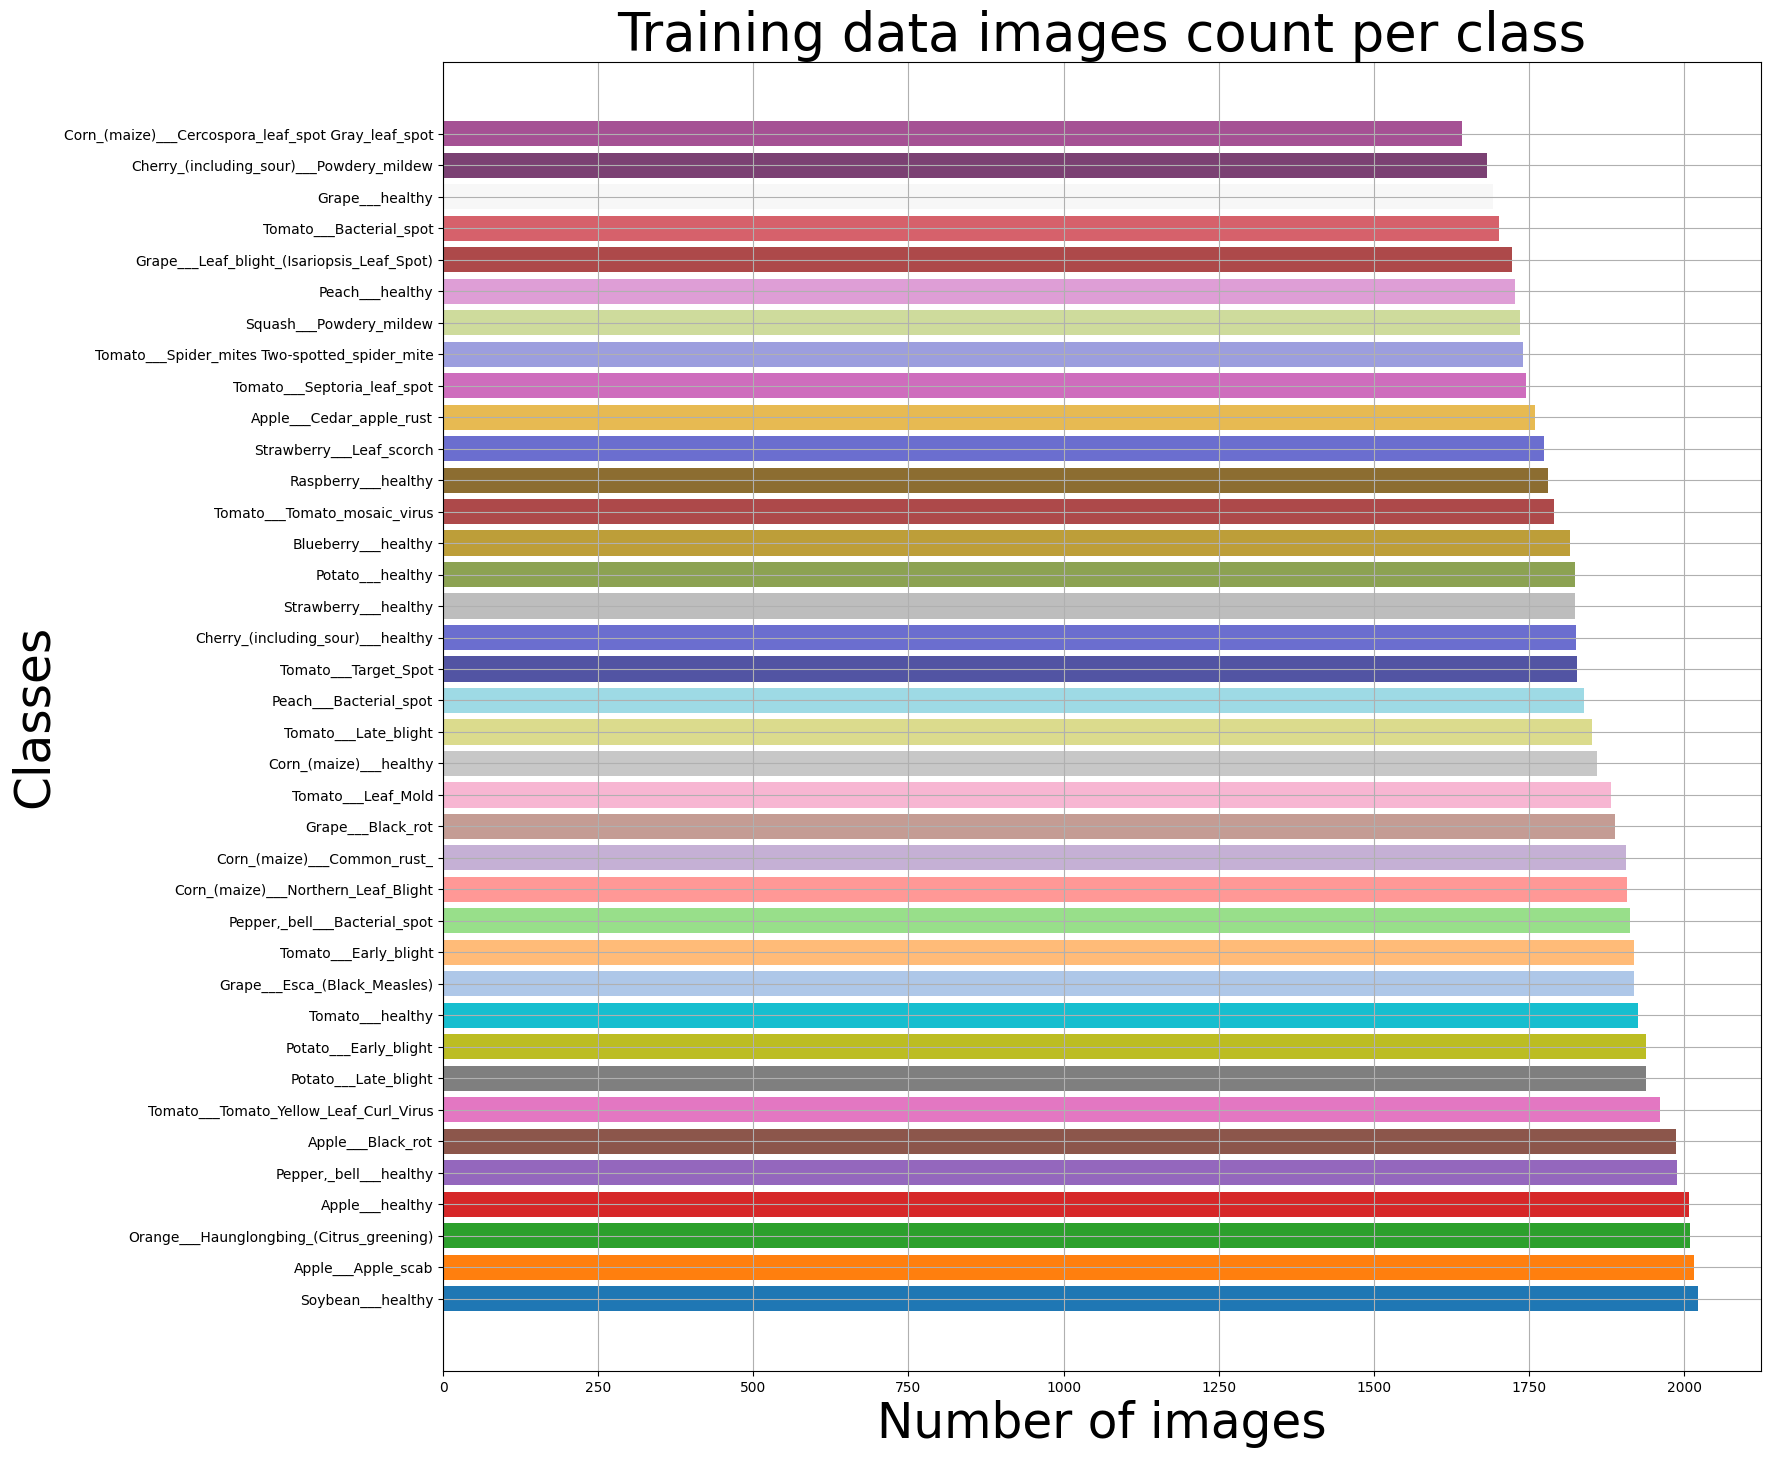

In [17]:
train  = train_df["labels"].value_counts()
label = train.tolist()
index = train.index.tolist()

colors = [
    "#1f77b4", "#ff7f0e", "#2ca02c", "#d62728", "#9467bd",
    "#8c564b", "#e377c2", "#7f7f7f", "#bcbd22", "#17becf",
    "#aec7e8", "#ffbb78", "#98df8a", "#ff9896", "#c5b0d5",
    "#c49c94", "#f7b6d2", "#c7c7c7", "#dbdb8d", "#9edae5",
    "#5254a3", "#6b6ecf", "#bdbdbd", "#8ca252", "#bd9e39",
    "#ad494a", "#8c6d31", "#6b6ecf", "#e7ba52", "#ce6dbd",
    "#9c9ede", "#cedb9c", "#de9ed6", "#ad494a", "#d6616b",
    "#f7f7f7", "#7b4173", "#a55194", "#ce6dbd"
]



plt.figure(figsize=(17,17))
plt.title("Training data images count per class",fontsize=38)
plt.xlabel('Number of images', fontsize=35)
plt.ylabel('Classes', fontsize=35)
plt.barh(index,label, color=colors)
plt.grid(True)
plt.show()

In [18]:
train_df.sample(n=15, random_state=1)

imgpath  \
59490  D:\PycharmProjects\Plant Disease Classificatio...   
58840  D:\PycharmProjects\Plant Disease Classificatio...   
11750  D:\PycharmProjects\Plant Disease Classificatio...   
19617  D:\PycharmProjects\Plant Disease Classificatio...   
48429  D:\PycharmProjects\Plant Disease Classificatio...   
46935  D:\PycharmProjects\Plant Disease Classificatio...   
42758  D:\PycharmProjects\Plant Disease Classificatio...   
33007  D:\PycharmProjects\Plant Disease Classificatio...   
42522  D:\PycharmProjects\Plant Disease Classificatio...   
43380  D:\PycharmProjects\Plant Disease Classificatio...   
59502  D:\PycharmProjects\Plant Disease Classificatio...   
61584  D:\PycharmProjects\Plant Disease Classificatio...   
49104  D:\PycharmProjects\Plant Disease Classificatio...   
58274  D:\PycharmProjects\Plant Disease Classificatio...   
53481  D:\PycharmProjects\Plant Disease Classificatio...   

                                         labels  encoded_labels  
59490                        Tomato___Leaf_Mold              31  
58840                      Tomato___Late_blight              30  
11750  Cherry_(including_sour)___Powdery_mildew               5  
19617       Corn_(maize)___Northern_Leaf_Blight               9  
48429                      Strawberry___healthy              27  
46935                   Squash___Powdery_mildew              25  
42758                      Potato___Late_blight              21  
33007                           Peach___healthy              17  
42522                      Potato___Late_blight              21  
43380                       Raspberry___healthy              23  
59502                        Tomato___Leaf_Mold              31  
61584               Tomato___Septoria_leaf_spot              32  
49104                      Strawberry___healthy              27  
58274                      Tomato___Late_blight              30  
53481                   Tomato___Bacterial_spot              28

In [19]:
print("----------Train-------------")
print(train_df[["imgpath", "labels"]].head(5))
print(train_df.shape)
print("--------Validation----------")
print(valid_df[["imgpath", "labels"]].head(5))
print(valid_df.shape)
print("----------Test--------------")
print(test_df[["imgpath", "labels"]].head(5))
print(test_df.shape)

----------Train-------------
                                             imgpath              labels
0  D:\PycharmProjects\Plant Disease Classificatio...  Apple___Apple_scab
1  D:\PycharmProjects\Plant Disease Classificatio...  Apple___Apple_scab
2  D:\PycharmProjects\Plant Disease Classificatio...  Apple___Apple_scab
3  D:\PycharmProjects\Plant Disease Classificatio...  Apple___Apple_scab
4  D:\PycharmProjects\Plant Disease Classificatio...  Apple___Apple_scab
(70295, 3)
--------Validation----------
                                             imgpath  \
0  D:\PycharmProjects\Plant Disease Classificatio...   
1  D:\PycharmProjects\Plant Disease Classificatio...   
2  D:\PycharmProjects\Plant Disease Classificatio...   
3  D:\PycharmProjects\Plant Disease Classificatio...   
4  D:\PycharmProjects\Plant Disease Classificatio...   

                        labels  
0        Potato___Early_blight  
1  Tomato___Septoria_leaf_spot  
2         Tomato___Late_blight  
3           Tomato___Lea

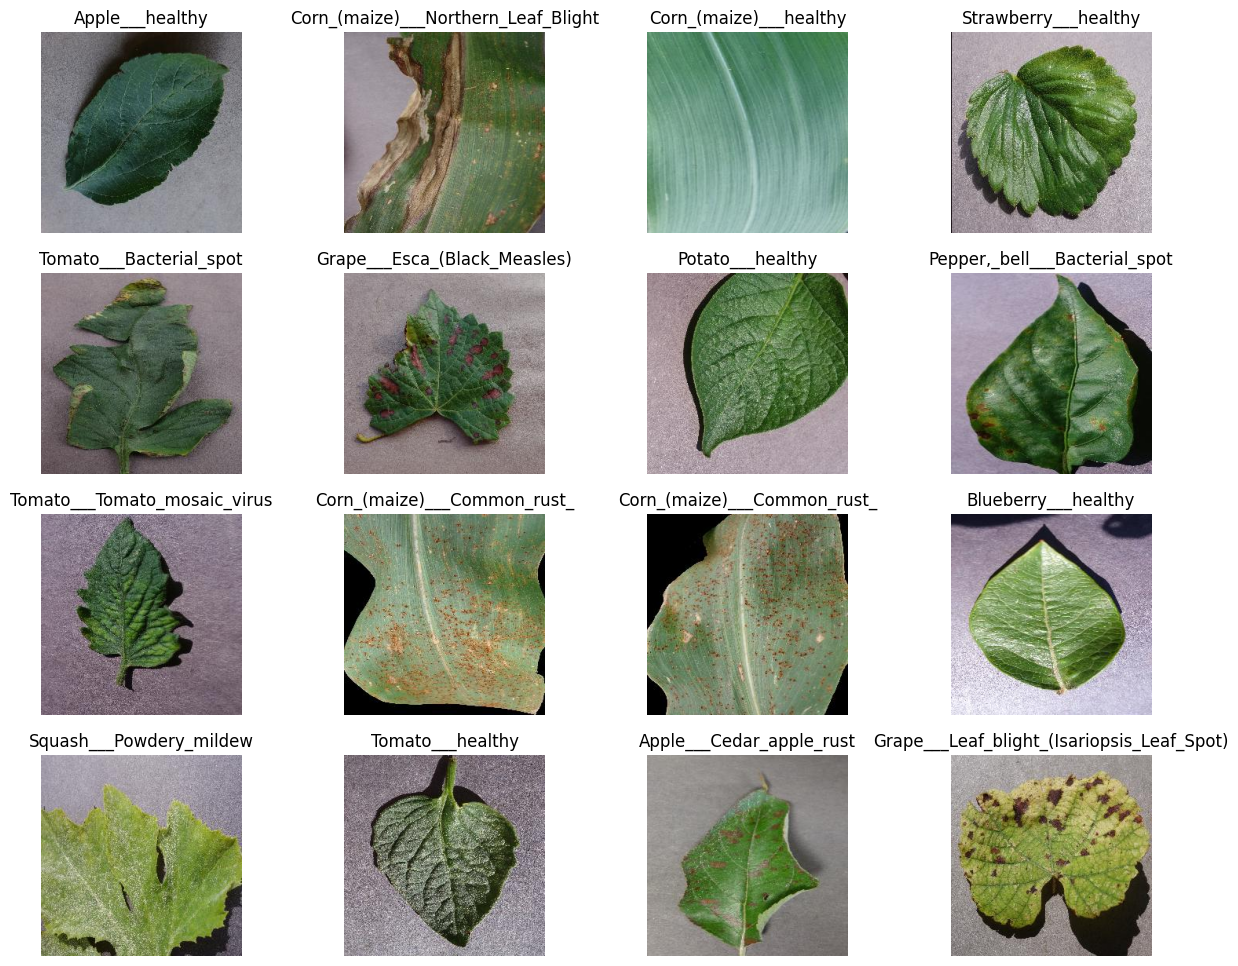

In [20]:
plt.figure(figsize=(15,12))
for i, row in valid_df.sample(n=16).reset_index().iterrows():
    plt.subplot(4,4,i+1)
    image_path = row['imgpath']
    image = Image.open(image_path)
    plt.imshow(image)
    plt.title(row["labels"])
    plt.axis('off')
plt.show()

In [21]:
%%time

BATCH_SIZE = 16
IMAGE_SIZE = (224, 224)


generator = ImageDataGenerator(
    preprocessing_function = tf.keras.applications.efficientnet.preprocess_input,
    # there could be image augmentation here
)

# Split the data into three categories.
train_images = generator.flow_from_dataframe(
    dataframe=train_df,
    x_col='imgpath',
    y_col='labels',
    target_size=IMAGE_SIZE,
    color_mode='rgb',
    class_mode='categorical',
    batch_size=BATCH_SIZE,
    shuffle=True,
    seed=42,
)

val_images = generator.flow_from_dataframe(
    dataframe=valid_df,
    x_col='imgpath',
    y_col='labels',
    target_size=IMAGE_SIZE,
    color_mode='rgb',
    class_mode='categorical',
    batch_size=BATCH_SIZE,
    shuffle=False
)

test_images = generator.flow_from_dataframe(
    dataframe=test_df,
    x_col='imgpath',
    y_col='labels',
    target_size=IMAGE_SIZE,
    color_mode='rgb',
    class_mode='categorical',
    batch_size=BATCH_SIZE,
    shuffle=False
)

Found 70295 validated image filenames belonging to 38 classes.
Found 15814 validated image filenames belonging to 38 classes.
Found 1758 validated image filenames belonging to 38 classes.
CPU times: total: 2.56 s
Wall time: 3.6 s


In [22]:
# Load the pretained model
pretrained_model = tf.keras.applications.EfficientNetB5(
    input_shape=(224, 224, 3),
    include_top=False, # we don`t need a pre-trained top layer (output layer)
    weights='imagenet',
    pooling='max'
)

# Freezing the layers of a pretrained neural network
for i, layer in enumerate(pretrained_model.layers):
    pretrained_model.layers[i].trainable = False

In [23]:
num_classes = len(set(train_images.classes))


# Data Augmentation Step
augment = tf.keras.Sequential([
  layers.experimental.preprocessing.RandomFlip("horizontal"),
  layers.experimental.preprocessing.RandomRotation(0.1),
  layers.experimental.preprocessing.RandomZoom(0.1),
  layers.experimental.preprocessing.RandomContrast(0.1),
], name='AugmentationLayer')



inputs = layers.Input(shape = (224,224,3), name='inputLayer')
x = augment(inputs)
pretrain_out = pretrained_model(x, training = False)
x = layers.Dense(256)(pretrain_out)
x = layers.Activation(activation="relu")(x) 
x = BatchNormalization()(x)
x = layers.Dropout(0.3)(x)
x = layers.Dense(num_classes)(x)
outputs = layers.Activation(activation="softmax", dtype=tf.float32, name='activationLayer')(x) # mixed_precision need separated Dense and Activation layers
model = Model(inputs=inputs, outputs=outputs)

#model.load_weights('./checkpoints/my_checkpoint')

model.compile(
    optimizer=Adam(0.0005),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

print(model.summary())

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inputLayer (InputLayer)     [(None, 224, 224, 3)]     0         
                                                                 
 AugmentationLayer (Sequenti  (None, 224, 224, 3)      0         
 al)                                                             
                                                                 
 efficientnetb5 (Functional)  (None, 2048)             28513527  
                                                                 
 dense_2 (Dense)             (None, 256)               524544    
                                                                 
 activation_1 (Activation)   (None, 256)               0         
                                                                 
 batch_normalization_1 (Batc  (None, 256)              1024      
 hNormalization)                                           

In [24]:
history = model.fit(
    train_images,
    steps_per_epoch=len(train_images),
    validation_data=val_images,
    validation_steps=len(val_images),
    epochs=10,
    callbacks=[
        EarlyStopping(monitor = "val_loss", # watch the val loss metric
                               patience = 3,
                               restore_best_weights = True), 
        ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2, mode='min') 
    ]
)
model.save_weights('./checkpoints/my_checkpoint')

Epoch 1/10
4394/4394 [==============================] - 334s 74ms/step - loss: 0.8251 - accuracy: 0.7701 - val_loss: 0.5589 - val_accuracy: 0.8299 - lr: 5.0000e-04
Epoch 2/10
4394/4394 [==============================] - 335s 76ms/step - loss: 0.5687 - accuracy: 0.8296 - val_loss: 0.7641 - val_accuracy: 0.7751 - lr: 5.0000e-04
Epoch 3/10
4394/4394 [==============================] - 332s 76ms/step - loss: 0.5276 - accuracy: 0.8372 - val_loss: 0.4697 - val_accuracy: 0.8466 - lr: 5.0000e-04
Epoch 4/10
4394/4394 [==============================] - 325s 74ms/step - loss: 0.5212 - accuracy: 0.8382 - val_loss: 0.5314 - val_accuracy: 0.8259 - lr: 5.0000e-04
Epoch 5/10
4394/4394 [==============================] - 336s 77ms/step - loss: 0.5454 - accuracy: 0.8303 - val_loss: 0.4285 - val_accuracy: 0.8669 - lr: 5.0000e-04
Epoch 6/10
4394/4394 [==============================] - 336s 76ms/step - loss: 0.5880 - accuracy: 0.8166 - val_loss: 0.4741 - val_accuracy: 0.8438 - lr: 5.0000e-04
Epoch 7/10
4394/

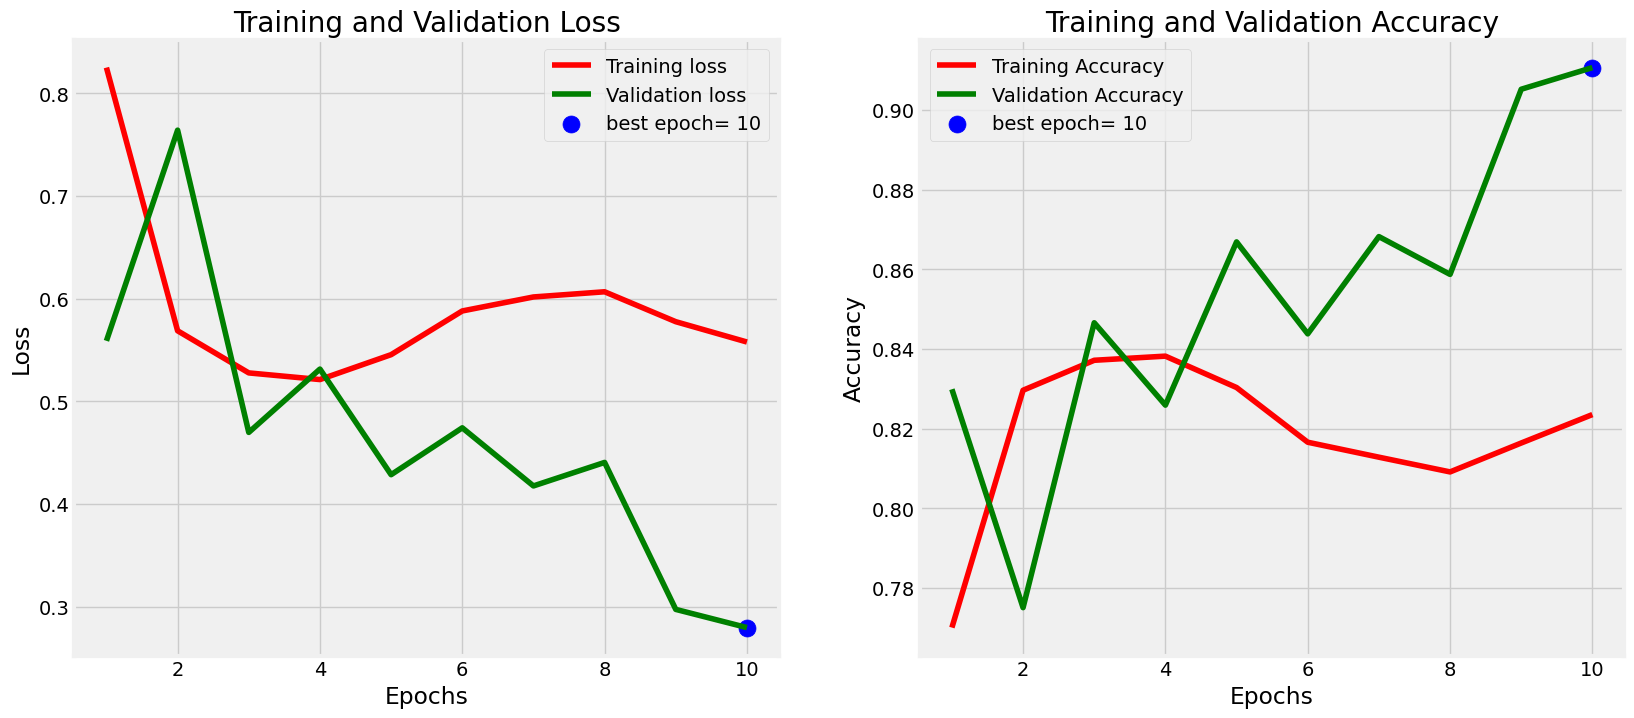

In [25]:
tr_acc = history.history['accuracy']
tr_loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']
index_loss = np.argmin(val_loss)
val_lowest = val_loss[index_loss]
index_acc = np.argmax(val_acc)
acc_highest = val_acc[index_acc]
Epochs = [i+1 for i in range(len(tr_acc))]
loss_label = f'best epoch= {str(index_loss + 1)}'
acc_label = f'best epoch= {str(index_acc + 1)}'

# Plot training history
plt.figure(figsize= (20, 8))
plt.style.use('fivethirtyeight')

plt.subplot(1, 2, 1)
plt.plot(Epochs, tr_loss, 'r', label= 'Training loss')
plt.plot(Epochs, val_loss, 'g', label= 'Validation loss')
plt.scatter(index_loss + 1, val_lowest, s= 150, c= 'blue', label= loss_label)
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(Epochs, tr_acc, 'r', label= 'Training Accuracy')
plt.plot(Epochs, val_acc, 'g', label= 'Validation Accuracy')
plt.scatter(index_acc + 1 , acc_highest, s= 150, c= 'blue', label= acc_label)
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout
plt.show()

In [26]:
pretrained_model.trainable = True
for layer in pretrained_model.layers:
    if isinstance(layer, layers.BatchNormalization): # set BatchNorm layers as not trainable
        layer.trainable = False
        
# let`s see first 10 layers
for l in pretrained_model.layers[:10]:
    print(l.name, l.trainable)

model.compile(
    optimizer=Adam(0.00001), # fine tuning requires very little learning rate
    loss='categorical_crossentropy',
    metrics=['accuracy']
)
# model.load_weights('./checkpoints/my_checkpoint')
print(model.summary())
history = model.fit(
    train_images,
    steps_per_epoch=len(train_images),
    validation_data=val_images,
    validation_steps=len(val_images),
    epochs=3,
    callbacks=[
        EarlyStopping(monitor = "val_loss", # watch the val loss metric
                               patience = 5,
                               restore_best_weights = True), # if val loss decreases for 5 epochs in a row, stop training,
        ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2, mode='min') 
    ]
)
model.save_weights('./checkpoints/my_checkpoint')

input_2 True
rescaling_1 True
normalization_1 True
stem_conv_pad True
stem_conv True
stem_bn False
stem_activation True
block1a_dwconv True
block1a_bn False
block1a_activation True
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inputLayer (InputLayer)     [(None, 224, 224, 3)]     0         
                                                                 
 AugmentationLayer (Sequenti  (None, 224, 224, 3)      0         
 al)                                                             
                                                                 
 efficientnetb5 (Functional)  (None, 2048)             28513527  
                                                                 
 dense_2 (Dense)             (None, 256)               524544    
                                                                 
 activation_1 (Activation)   (None, 256)               0         
          

In [27]:
model.save('./saved_models/plant_disease_classification.h5')

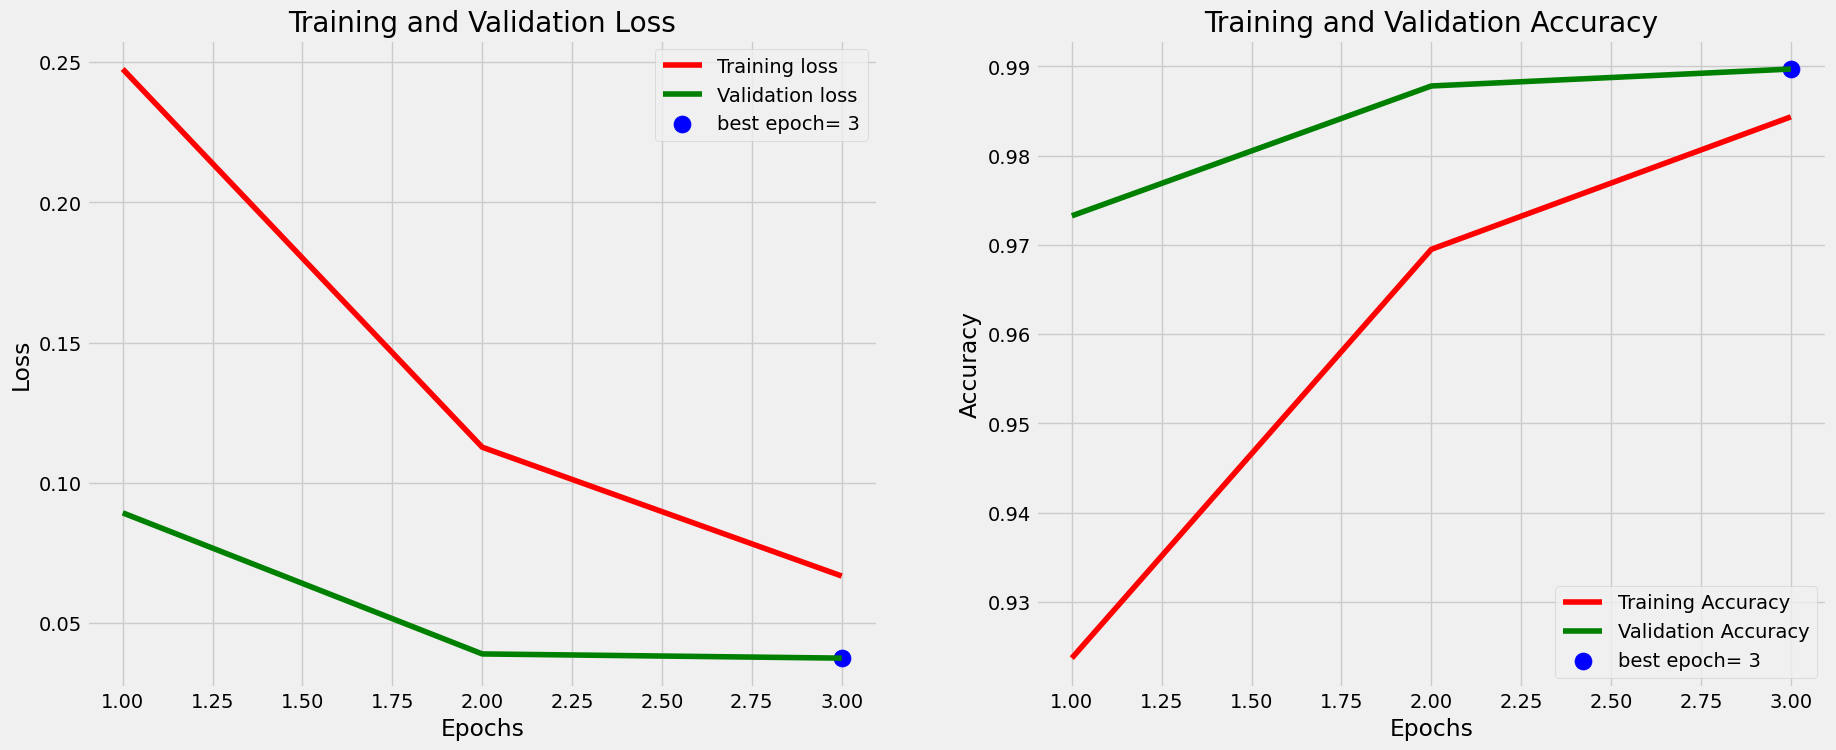

In [28]:
# Define needed variables
tr_acc = history.history['accuracy']
tr_loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']
index_loss = np.argmin(val_loss)
val_lowest = val_loss[index_loss]
index_acc = np.argmax(val_acc)
acc_highest = val_acc[index_acc]
Epochs = [i+1 for i in range(len(tr_acc))]
loss_label = f'best epoch= {str(index_loss + 1)}'
acc_label = f'best epoch= {str(index_acc + 1)}'

# Plot training history
plt.figure(figsize= (20, 8))
plt.style.use('fivethirtyeight')

plt.subplot(1, 2, 1)
plt.plot(Epochs, tr_loss, 'r', label= 'Training loss')
plt.plot(Epochs, val_loss, 'g', label= 'Validation loss')
plt.scatter(index_loss + 1, val_lowest, s= 150, c= 'blue', label= loss_label)
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(Epochs, tr_acc, 'r', label= 'Training Accuracy')
plt.plot(Epochs, val_acc, 'g', label= 'Validation Accuracy')
plt.scatter(index_acc + 1 , acc_highest, s= 150, c= 'blue', label= acc_label)
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout
plt.show()

In [29]:
results = model.evaluate(test_images, verbose=0)

print("    Test Loss: {:.5f}".format(results[0]))
print("Test Accuracy: {:.2f}%".format(results[1] * 100))

    Test Loss: 0.02701
Test Accuracy: 99.32%


In [30]:
y_true = test_images.classes
y_pred = np.argmax(model.predict(test_images), axis = 1)
f1 = f1_score(y_true, y_pred, average='macro')
print("F1 Score:", f1)
print(classification_report(y_true, y_pred, target_names=test_images.class_indices.keys()))

F1 Score: 0.9933017985148829
                                                    precision    recall  f1-score   support

                                Apple___Apple_scab       1.00      1.00      1.00        58
                                 Apple___Black_rot       1.00      1.00      1.00        53
                          Apple___Cedar_apple_rust       1.00      0.97      0.99        40
                                   Apple___healthy       1.00      1.00      1.00        53
                               Blueberry___healthy       1.00      1.00      1.00        40
          Cherry_(including_sour)___Powdery_mildew       1.00      1.00      1.00        37
                 Cherry_(including_sour)___healthy       1.00      1.00      1.00        47
Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot       0.95      0.97      0.96        36
                       Corn_(maize)___Common_rust_       1.00      1.00      1.00        44
               Corn_(maize)___Northern_Leaf_Blight

In [31]:
classes = dict(zip(test_images.class_indices.values(), test_images.class_indices.keys()))
Predictions = pd.DataFrame({"Image Index" : list(range(len(test_images.labels))), 
                            "Test Labels" : test_images.labels, 
                            "Test Classes" : [classes[i] for i in test_images.labels],
                            "Prediction Labels" : y_pred,
                            "Prediction Classes" : [classes[i] for i in y_pred],
                            "Path": test_images.filenames,
                            "Prediction Probability" : [x for x in np.asarray(tf.reduce_max(model.predict(test_images), axis = 1))]
                           })
Predictions.head(8)

Image Index  Test Labels                            Test Classes  \
0            0            1                       Apple___Black_rot   
1            1           29                   Tomato___Early_blight   
2            2           37                        Tomato___healthy   
3            3           24                       Soybean___healthy   
4            4           31                      Tomato___Leaf_Mold   
5            5           35  Tomato___Tomato_Yellow_Leaf_Curl_Virus   
6            6           31                      Tomato___Leaf_Mold   
7            7           19                  Pepper,_bell___healthy   

   Prediction Labels                      Prediction Classes  \
0                  1                       Apple___Black_rot   
1                 29                   Tomato___Early_blight   
2                 37                        Tomato___healthy   
3                 24                       Soybean___healthy   
4                 31                      Tomato___Leaf_Mold   
5                 35  Tomato___Tomato_Yellow_Leaf_Curl_Virus   
6                 31                      Tomato___Leaf_Mold   
7                 19                  Pepper,_bell___healthy   

                                                Path  Prediction Probability  
0  D:\PycharmProjects\Plant Disease Classificatio...                0.999859  
1  D:\PycharmProjects\Plant Disease Classificatio...                0.995387  
2  D:\PycharmProjects\Plant Disease Classificatio...                0.999901  
3  D:\PycharmProjects\Plant Disease Classificatio...                0.999973  
4  D:\PycharmProjects\Plant Disease Classificatio...                0.999227  
5  D:\PycharmProjects\Plant Disease Classificatio...                0.999223  
6  D:\PycharmProjects\Plant Disease Classificatio...                0.999905  
7  D:\PycharmProjects\Plant Disease Classificatio...                0.999703

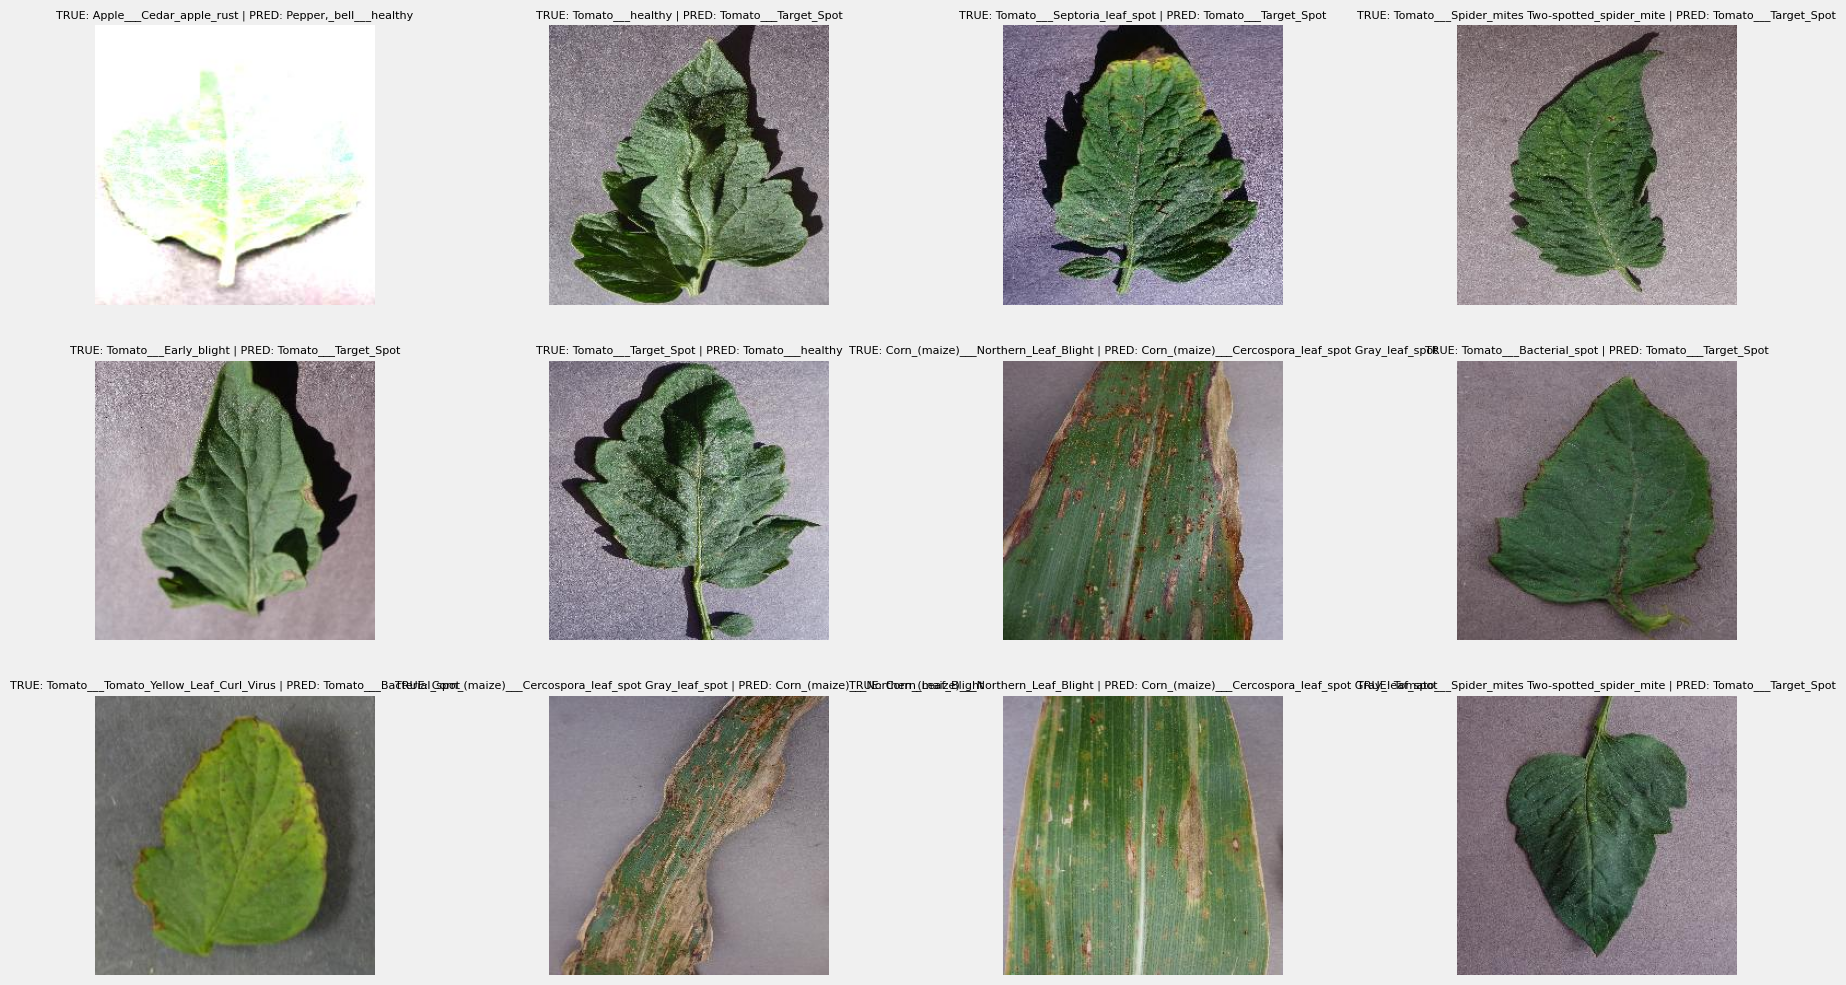

In [32]:
plt.figure(figsize=(20,20))
for i, row in Predictions[Predictions["Test Labels"] != Predictions["Prediction Labels"]].sort_values("Prediction Probability").tail(20).reset_index().iterrows():
    plt.subplot(5,4,i+1)
    image_path = row['Path']
    image = Image.open(image_path)
    plt.imshow(image)
    plt.title(f'TRUE: {row["Test Classes"]} | PRED: {row["Prediction Classes"]}', fontsize=8)
    plt.axis('off')
    
plt.show()

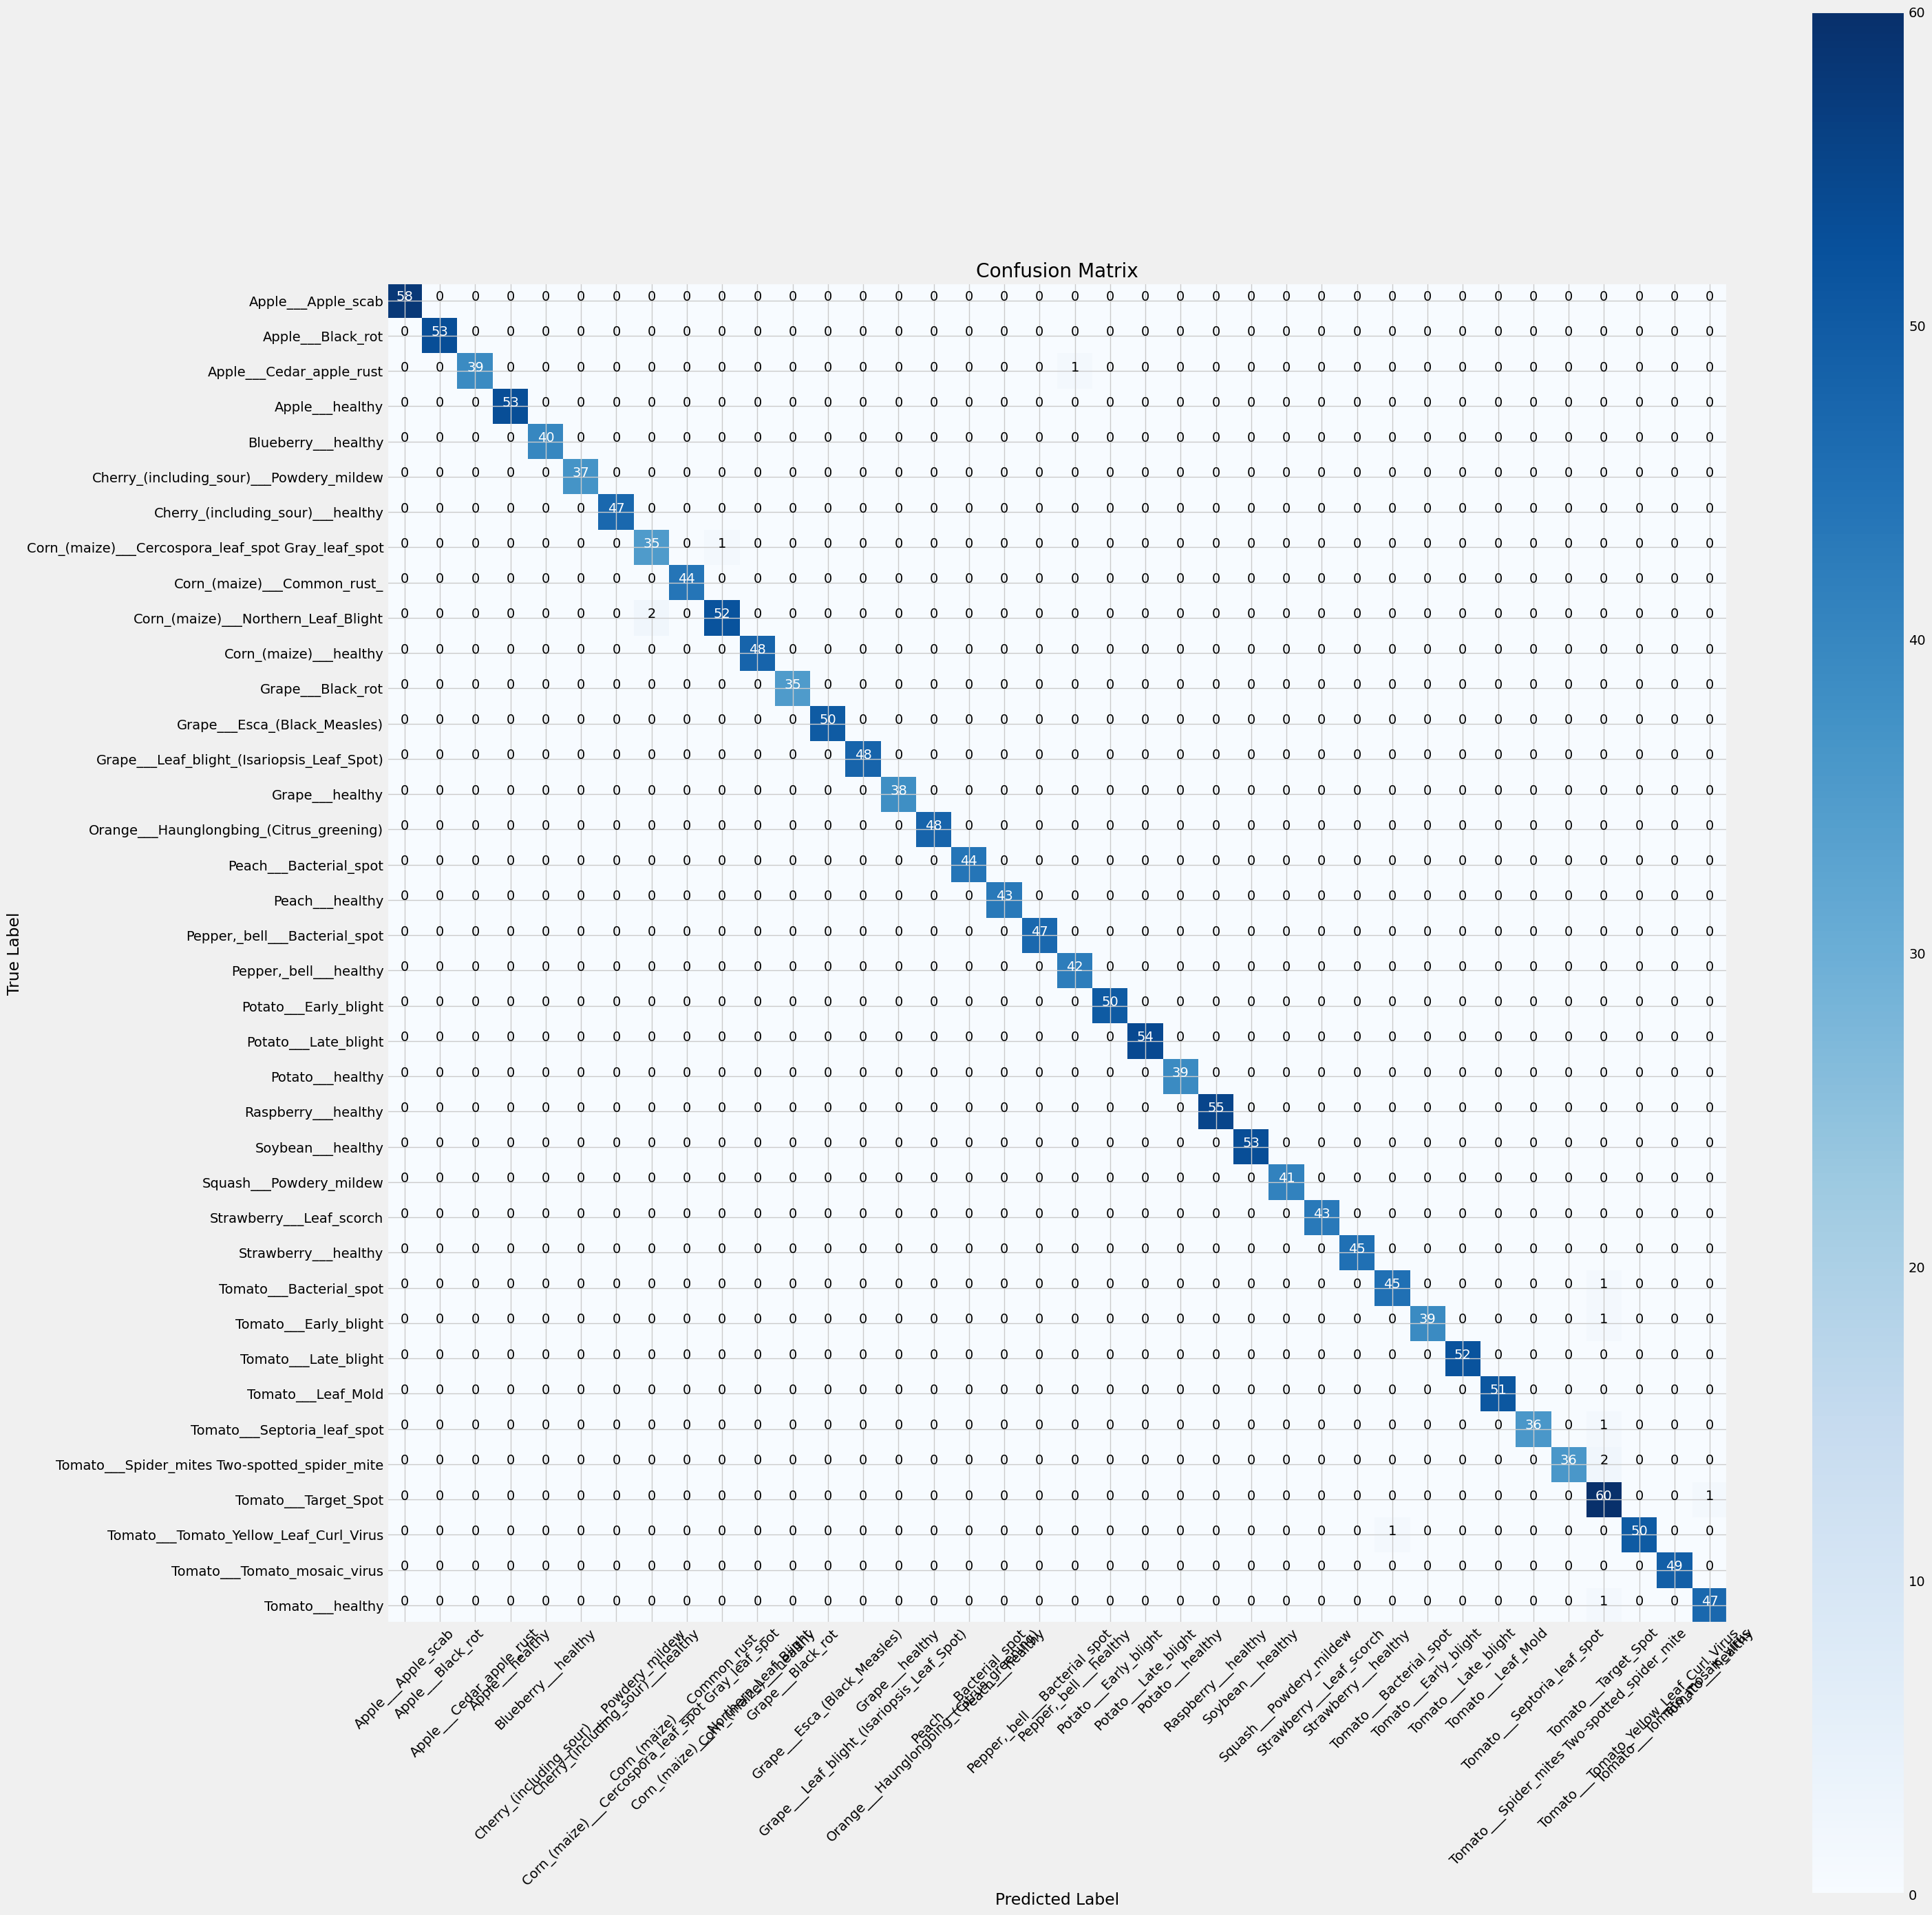

In [33]:
preds = model.predict_generator(test_images)
y_pred = np.argmax(preds, axis=1)
g_dict = test_images.class_indices
classes = list(g_dict.keys())

# Confusion matrix
cm = confusion_matrix(test_images.classes, y_pred)

plt.figure(figsize= (30, 30))
plt.imshow(cm, interpolation= 'nearest', cmap= plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()

tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation= 45)
plt.yticks(tick_marks, classes)


thresh = cm.max() / 2.
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, cm[i, j], horizontalalignment= 'center', color= 'white' if cm[i, j] > thresh else 'black')

plt.tight_layout()
plt.ylabel('True Label')
plt.xlabel('Predicted Label')

plt.show()

In [34]:
model.save_weights('./checkpoints/my_checkpoint')

In [35]:
model.save('./saved_models/plant_disease_classification.h5')